In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## part I

In [4]:
df_crsp = pd.read_csv(r"D:\1YFT_Math_and_Finance\Autumn\Portfolio Management\wtiyx1gpw5qo2mba.csv.gz", na_values=['C'], parse_dates=['date'])

# The output from WRDS returns a mixed of small and large cap column names.
# We can easily convert everything to small caps.
cols = df_crsp.columns
df_crsp.columns = [c.lower() for c in cols]
df_crsp.drop_duplicates(keep='first',inplace=True)
df_crsp.reset_index(inplace=True,drop=True)
df_crsp = df_crsp[df_crsp['exchcd'] == 1.0]
df_crsp['ret'] = pd.to_numeric(df_crsp['ret'], errors='coerce')

df_crsp

,permno,date,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd
916,10006,1925-12-31,1.0,22156,109.00000,NaN,NaN,600.0,NaN,NaN
917,10006,1926-01-30,1.0,22156,110.25000,753.0,0.032732,600.0,0.000561,0.023174
918,10006,1926-02-27,1.0,22156,102.37500,342.0,-0.071429,600.0,-0.033046,-0.053510
919,10006,1926-03-31,1.0,22156,96.50000,489.0,-0.042735,600.0,-0.064002,-0.096824
920,10006,1926-04-30,1.0,22156,94.00000,249.0,-0.025907,600.0,0.037029,0.032975
...,...,...,...,...,...,...,...,...,...,...
5041302,93427,2023-08-31,1.0,53445,160.77000,100449.0,0.300307,36191.0,-0.020605,-0.052542
5041303,93427,2023-09-29,1.0,53445,166.62000,64970.0,0.036387,36191.0,-0.047390,-0.055443
5041304,93427,2023-10-31,1.0,53445,155.00000,77214.0,-0.069739,36331.0,-0.028867,-0.060887
5041305,93427,2023-11-30,1.0,53445,161.89999,68822.0,0.044516,36331.0,0.092057,0.080251


In [5]:
# 筛选出1926年的数据,这一步是在check有多少上市公司
data_1926 = df_crsp[df_crsp['date'].dt.year == 1926]  
# 根据 permno 去重，统计公司数量
unique_companies = data_1926['permno'].nunique()
unique_companies

565

In [6]:
df_crsp['prc'] = abs(df_crsp['prc'])#取绝对值

df_crsp

,permno,date,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd
916,10006,1925-12-31,1.0,22156,109.00000,NaN,NaN,600.0,NaN,NaN
917,10006,1926-01-30,1.0,22156,110.25000,753.0,0.032732,600.0,0.000561,0.023174
918,10006,1926-02-27,1.0,22156,102.37500,342.0,-0.071429,600.0,-0.033046,-0.053510
919,10006,1926-03-31,1.0,22156,96.50000,489.0,-0.042735,600.0,-0.064002,-0.096824
920,10006,1926-04-30,1.0,22156,94.00000,249.0,-0.025907,600.0,0.037029,0.032975
...,...,...,...,...,...,...,...,...,...,...
5041302,93427,2023-08-31,1.0,53445,160.77000,100449.0,0.300307,36191.0,-0.020605,-0.052542
5041303,93427,2023-09-29,1.0,53445,166.62000,64970.0,0.036387,36191.0,-0.047390,-0.055443
5041304,93427,2023-10-31,1.0,53445,155.00000,77214.0,-0.069739,36331.0,-0.028867,-0.060887
5041305,93427,2023-11-30,1.0,53445,161.89999,68822.0,0.044516,36331.0,0.092057,0.080251


In [7]:
from collections import defaultdict

# 确保 'date' 列是 datetime 格式
df_crsp['date'] = pd.to_datetime(df_crsp['date'])

# 起始年份和截止年份
start_year = 1926
end_year = 2023
start_month = 1

# 初始化变量
date = []
valid_firm_number = []
total_number = []
filter_all_data = defaultdict(list)

# 按年份逐年递增
for year in range(start_year, end_year + 1):
    sum_valid = 0  # 累计连续85个月的次数
    total_tests = 0  # 总的测试次数
    # 计算当前循环的起始时间
    start_date = pd.Timestamp(year=year, month=start_month, day=1)
    end_date = start_date + pd.DateOffset(months=85)  # 85个月的截止时间

    date.append(start_date.date())

    # 筛选在当前时间范围内的数据
    need_data = df_crsp.copy(deep=True)
    need_data.dropna(inplace=True)
    filtered_data = need_data[(need_data['date'] >= start_date)]
    grouped_data = filtered_data.groupby('permno').filter(
        lambda x: (x['date'].iloc[0].year == start_date.year) and (x['date'].iloc[0].month == start_date.month)
    )
    grouped_data = grouped_data.groupby('permno')  # 再次按 permno 分组

    # 遍历每个分组，判断前85个月的连续性
    for idx, group in grouped_data:
        total_tests += 1  # 统计总测试次数

        # 提取当前分组前85个月的数据
        first_85 = group.head(85).copy()
        first_85['year'] = first_85['date'].dt.year
        first_85['month'] = first_85['date'].dt.month
        first_85['month_number'] = (first_85['year'] - first_85['year'].iloc[0]) * 12 + first_85['month']

        # 判断连续性
        first_85['month_diff'] = first_85['month_number'].diff().fillna(1)
        first_85['is_consecutive'] = first_85['month_diff'] == 1

        if first_85['is_consecutive'].all():
            sum_valid += 1
            filter_all_data[start_date.date()].append(idx)

    valid_firm_number.append(sum_valid)
    total_number.append(total_tests)

# 输出结果
for i in range(len(date)):
    print(
        f"起始日期:{date[i]}, 符合要求公司比例: {valid_firm_number[i] / total_number[i]:.2%}, "
        f"符合要求公司总数: {valid_firm_number[i]}, 有效公司总数: {total_number[i]}"
    )

del need_data


起始日期:1926-01-01, 符合要求公司比例: 70.91%, 符合要求公司总数: 351, 有效公司总数: 495
起始日期:1927-01-01, 符合要求公司比例: 73.47%, 符合要求公司总数: 396, 有效公司总数: 539
起始日期:1928-01-01, 符合要求公司比例: 73.25%, 符合要求公司总数: 430, 有效公司总数: 587
起始日期:1929-01-01, 符合要求公司比例: 72.57%, 符合要求公司总数: 455, 有效公司总数: 627
起始日期:1930-01-01, 符合要求公司比例: 76.07%, 符合要求公司总数: 550, 有效公司总数: 723
起始日期:1931-01-01, 符合要求公司比例: 79.75%, 符合要求公司总数: 583, 有效公司总数: 731
起始日期:1932-01-01, 符合要求公司比例: 83.79%, 符合要求公司总数: 610, 有效公司总数: 728
起始日期:1933-01-01, 符合要求公司比例: 86.28%, 符合要求公司总数: 610, 有效公司总数: 707
起始日期:1934-01-01, 符合要求公司比例: 90.07%, 符合要求公司总数: 635, 有效公司总数: 705
起始日期:1935-01-01, 符合要求公司比例: 91.37%, 符合要求公司总数: 646, 有效公司总数: 707
起始日期:1936-01-01, 符合要求公司比例: 94.13%, 符合要求公司总数: 674, 有效公司总数: 716
起始日期:1937-01-01, 符合要求公司比例: 95.14%, 符合要求公司总数: 705, 有效公司总数: 741
起始日期:1938-01-01, 符合要求公司比例: 95.91%, 符合要求公司总数: 750, 有效公司总数: 782
起始日期:1939-01-01, 符合要求公司比例: 96.27%, 符合要求公司总数: 748, 有效公司总数: 777
起始日期:1940-01-01, 符合要求公司比例: 97.05%, 符合要求公司总数: 756, 有效公司总数: 779
起始日期:1941-01-01, 符合要求公司比例: 97.22%, 符合要求公司总数: 769, 有效公司总数: 791
起始日期:194

In [8]:
valid_firm_number

[351,
 396,
 430,
 455,
 550,
 583,
 610,
 610,
 635,
 646,
 674,
 705,
 750,
 748,
 756,
 769,
 779,
 784,
 795,
 814,
 850,
 902,
 935,
 953,
 973,
 993,
 1010,
 1022,
 1019,
 1019,
 1020,
 1014,
 1029,
 1016,
 1035,
 1067,
 1098,
 1128,
 1154,
 1196,
 1227,
 1241,
 1215,
 1214,
 1221,
 1250,
 1307,
 1380,
 1430,
 1431,
 1424,
 1490,
 1496,
 1511,
 1499,
 1509,
 1508,
 1481,
 1510,
 1502,
 1492,
 1518,
 1605,
 1620,
 1654,
 1713,
 1824,
 2040,
 2300,
 2476,
 2557,
 2739,
 2827,
 2841,
 2760,
 2569,
 2511,
 2512,
 2512,
 2578,
 2622,
 2656,
 2485,
 2402,
 2391,
 2427,
 2442,
 2481,
 2543,
 2606,
 2571,
 2482,
 2465,
 2446,
 2397,
 2422,
 2626,
 2520]

In [9]:
print(total_number)

[495, 539, 587, 627, 723, 731, 728, 707, 705, 707, 716, 741, 782, 777, 779, 791, 800, 803, 812, 829, 855, 908, 941, 965, 988, 1012, 1031, 1045, 1045, 1052, 1053, 1051, 1072, 1066, 1085, 1114, 1141, 1165, 1187, 1223, 1246, 1264, 1238, 1248, 1290, 1329, 1399, 1483, 1539, 1541, 1533, 1549, 1544, 1546, 1532, 1536, 1529, 1493, 1517, 1510, 1500, 1527, 1615, 1633, 1667, 1727, 1837, 2056, 2311, 2488, 2569, 2754, 2844, 2858, 2776, 2589, 2532, 2538, 2536, 2604, 2649, 2679, 2505, 2417, 2400, 2436, 2454, 2493, 2555, 2619, 2584, 2492, 2475, 2453, 2403, 2426, 2628, 2521]


In [10]:
#可以通过如下方式筛选出不同起始点所对应的满足连续85个月都有数值的要求的股票，数字为代码 permno
#filter_all_data[pd.to_datetime('1934-01-01').date()]

In [11]:
df_crsp[df_crsp['ret'] > 1].shape[0]

1394

In [12]:
def filter_consecutive_data(date, consecutive_months=84):
    start_date = date - pd.DateOffset(months=consecutive_months)
    return filter_all_data[pd.to_datetime(start_date).date()]

In [13]:
len(filter_consecutive_data(pd.to_datetime('1933-01-01'), consecutive_months=84))

351

In [14]:
df_crsp['lret'] = np.log(1 + df_crsp['ret'])
df_crsp['lvwretd'] = np.log(1 + df_crsp['vwretd'])
df_crsp['lewretd'] = np.log(1 + df_crsp['ewretd'])

# Compute the market cap
df_crsp['size'] = df_crsp['shrout'] * df_crsp['prc']

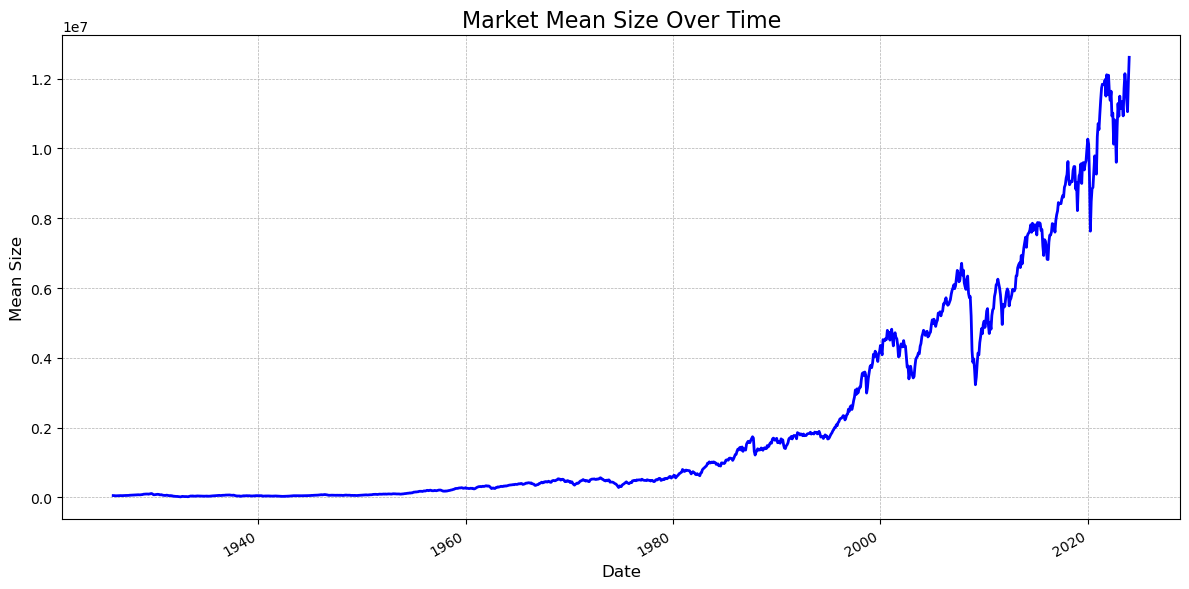

In [15]:
# Calculate and plot the mean size
plt.subplots(figsize=(12, 6))

df_crsp.groupby(['date'])['size'].mean().plot(color='blue', linewidth=2)
# Enhance the plot with grid, intercept, title, and labels
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.title('Market Mean Size Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean Size', fontsize=12)

# Show plot with enhancements
plt.tight_layout()
plt.show()

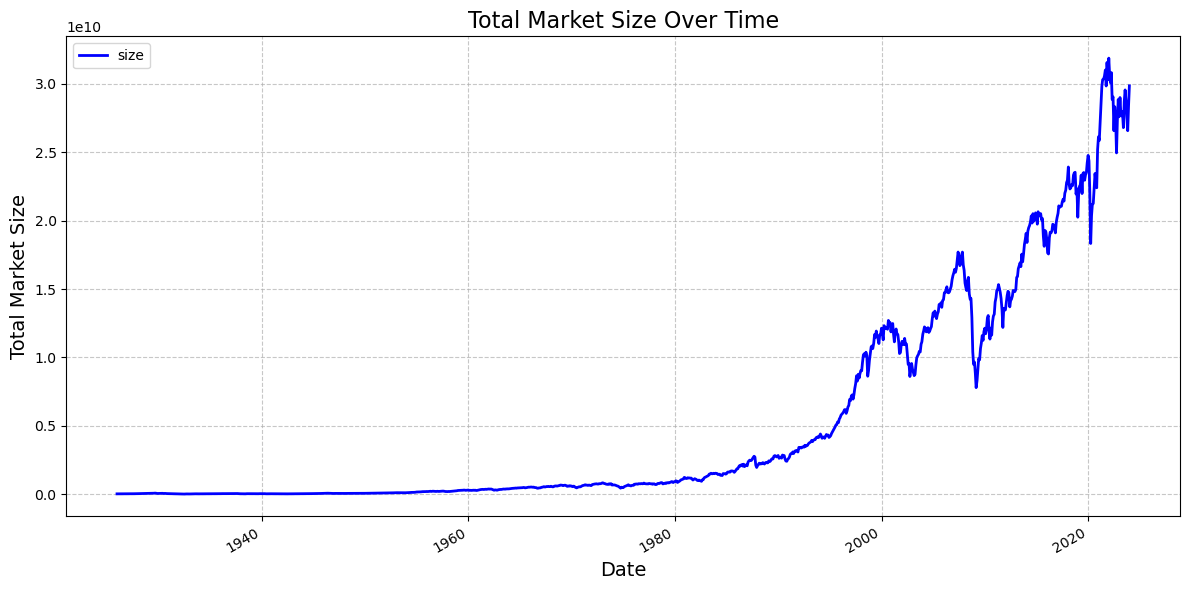

In [16]:
# Plotting total market size over time
fig, ax = plt.subplots(figsize=(12, 6))
df_crsp.groupby(['date'])['size'].sum().plot(color='blue', linewidth=2)

# Enhancing the plot
ax.set_title('Total Market Size Over Time', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Market Size', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


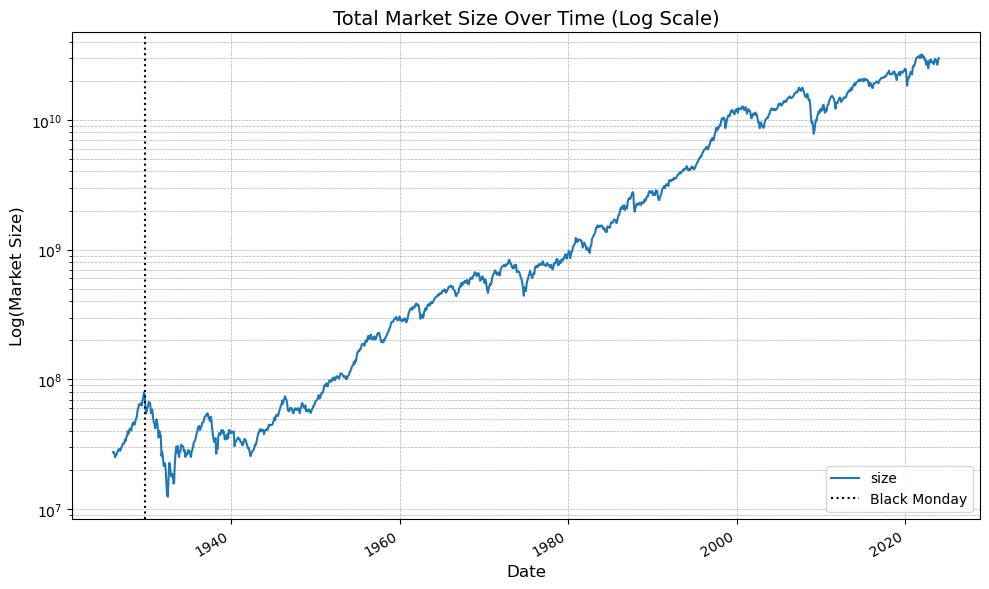

In [17]:

# Plot total market size over time in log scale
fig, ax = plt.subplots(figsize=(10, 6))
df_crsp.groupby(['date'])['size'].sum().plot(logy=True, ax=ax)

# Adding a vertical line for Black Monday
ax.axvline(x=datetime(1929, 10, 24), color='k', linestyle=':', label='Black Monday')

# Enhancing the plot
ax.set_title("Total Market Size Over Time (Log Scale)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Log(Market Size)", fontsize=12)
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Part II

In [18]:
df_crsp = df_crsp.set_index('date')
df_crsp = df_crsp.sort_index()

In [19]:
df_crsp

,permno,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,,,
1925-12-31,10006,1.0,22156,109.000,NaN,NaN,600.0,NaN,NaN,NaN,NaN,NaN,6.540000e+04
1925-12-31,13944,1.0,22484,35.750,NaN,NaN,175.0,NaN,NaN,NaN,NaN,NaN,6.256250e+03
1925-12-31,10911,1.0,22233,21.000,NaN,NaN,137.0,NaN,NaN,NaN,NaN,NaN,2.877000e+03
1925-12-31,10903,1.0,22232,37.750,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,3.661750e+03
1925-12-31,13952,1.0,22925,35.375,NaN,NaN,329.0,NaN,NaN,NaN,NaN,NaN,1.163838e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,15627,1.0,55386,73.000,215923.0,0.074477,85439.0,0.053468,0.08384,0.071834,0.052088,0.08051,6.237047e+06
2023-12-29,15649,1.0,55402,181.830,25227.0,0.074709,19404.0,0.053468,0.08384,0.072050,0.052088,0.08051,3.528229e+06
2023-12-29,85792,1.0,34660,215.800,205660.0,0.146461,145285.0,0.053468,0.08384,0.136680,0.052088,0.08051,3.135250e+07


In [121]:
# 计算36个月formation period，构建top bottom portfolio

def compute_performance_portfolios(hold_date, data, formation_period=36, use_deciles=True, n_stocks=35, benchmark='ewretd'):
    """
    Computes the top and bottom portfolios based on stock performance in the formation period prior to the given date.
    
    Parameters:
        hold_date (datetime): The portfolio hold date.
        data (DataFrame): DataFrame containing stock data with required columns like 'log_return', 'log_market_return', etc.
        formation_period (int): The number of months in the formation period.
        use_deciles (bool): Whether to use decile-based grouping or a fixed number of stocks.
        n_stocks (int): The number of top/bottom stocks if not using deciles.
        benchmark (str): The benchmark column name to compute excess returns.
        
    Returns:
        bottom_portfolio (DataFrame): DataFrame containing bottom portfolio stocks and their excess returns.
        top_portfolio (DataFrame): DataFrame containing top portfolio stocks and their excess returns.
    """
    if hold_date == pd.to_datetime('1932-1-1'):
        valid_list = filter_consecutive_data(hold_date, consecutive_months=72)
    else:
        valid_list = filter_consecutive_data(hold_date, consecutive_months=84)
    # Define the beginning date of the formation period
    start_date = hold_date - pd.DateOffset(months=formation_period)
    
    # Filter data for the formation period
    formation_data = data[
        (data.index >= start_date) & (data.index <= hold_date.to_pydatetime()) & (data['permno'].isin(valid_list))
        ].copy()
    # Group by stock_id and compute total log returns over the formation period
    stock_returns = formation_data.groupby('permno')[['lret', 'lvwretd', 'lewretd']].sum()
    # Compute excess returns based on the chosen benchmark
    stock_returns['lexret'] = stock_returns['lret'] - stock_returns['l' + benchmark]
    # Compute deciles and rankings for excess returns

    stock_returns['decile'] = pd.qcut(stock_returns['lexret'], 9, labels=False)  # (0 = worst, 9 = best)
    stock_returns['rank_asc'] = stock_returns['lexret'].rank()  # (1 = worst return)
    stock_returns['rank_desc'] = stock_returns['lexret'].rank(ascending=False)  # (1 = best return)

    numberofstock = 0
    # Select top and bottom portfolios
    if use_deciles:
        top_portfolio_test = stock_returns[stock_returns['decile'] == 8].reset_index()
        top_portfolio = stock_returns[stock_returns['decile'] == 8].reset_index()[['permno', 'lexret']]
        numberofstock = stock_returns[stock_returns['decile'] == 8].shape[0]
        bottom_portfolio_test = stock_returns[stock_returns['decile'] == 0].reset_index()
        bottom_portfolio = stock_returns[stock_returns['decile'] == 0].reset_index()[['permno', 'lexret']]
        
    else:
        top_portfolio_test = stock_returns[stock_returns['rank_desc'] <= n_stocks].reset_index()
        top_portfolio = stock_returns[stock_returns['rank_desc'] <= n_stocks].reset_index()[['permno', 'lexret']]
        bottom_portfolio = stock_returns[stock_returns['rank_asc'] <= n_stocks].reset_index()[['permno', 'lexret']]
        bottom_portfolio_test = stock_returns[stock_returns['rank_asc'] <= n_stocks].reset_index()

    def calculate_weights(portfolio, price_data, date):
        weights = portfolio.copy()
        weights['ew'] = 1.0 / len(portfolio)
        weights['date'] = date
        market_cap = pd.merge_asof(weights, 
                                 price_data[['permno', 'size']],
                                 by='permno',
                                 left_on='date',
                                 right_index=True)
        
        market_cap['vw'] = market_cap['size'] / market_cap['size'].sum()
        return market_cap[['permno', 'ew', 'vw']]

    def calculate_AR_CAR(stock_data,benchmark,weight_type):
        #first calcultae AR
        stock_data[f'weighted_ret'] = stock_data[weight_type] * stock_data['ret']
        stock_data[f'weighted_benchmark'] = stock_data[weight_type] * stock_data[benchmark]
    
        portfolio_returns = stock_data.groupby('date')[[f'weighted_ret', f'weighted_benchmark']].sum()
        #print(portfolio_returns)
        
        portfolio_returns = portfolio_returns.reset_index()
        portfolio_returns['months'] = range(1, len(portfolio_returns) + 1)
        portfolio_returns['AR'] = (portfolio_returns[f'weighted_ret'] - 
                                            portfolio_returns[f'weighted_benchmark'])
        #then use AR to calculate CAR
        portfolio_returns['CAR'] = portfolio_returns['AR'].cumsum()

        return portfolio_returns[['months', 'AR','CAR']]

    # Merge portfolio with price data to compute weights
    top_formation_data = formation_data[formation_data['permno'].isin(top_portfolio_test['permno'])]
    top_weights = calculate_weights(top_portfolio_test, top_formation_data, hold_date)
    
    # Compute CAR for the top portfolio
    top_portfolio_returns = pd.merge(top_formation_data.reset_index(), top_weights, on='permno')
    car_results_top = calculate_AR_CAR(top_portfolio_returns, benchmark,benchmark[:2])
    
    # Extract CAR at the end of the formation period
    car_top = car_results_top['CAR'].iloc[-1]  # Get CAR at the last date

    bottom_formation_data = formation_data[formation_data['permno'].isin(bottom_portfolio_test['permno'])]
    bottom_weights = calculate_weights(bottom_portfolio_test, bottom_formation_data, hold_date)
    
    # Compute CAR for the bottom portfolio
    bottom_portfolio_returns = pd.merge(bottom_formation_data.reset_index(), bottom_weights, on='permno')
    car_results_bottom = calculate_AR_CAR(bottom_portfolio_returns, benchmark,benchmark[:2])
    
    # Extract CAR at the end of the formation period
    car_bottom = car_results_bottom['CAR'].iloc[-1]  # Get CAR at the last date
    return bottom_portfolio, top_portfolio, numberofstock, car_top,car_bottom

In [221]:
#权重部分待修改
def calculate_portfolio_returns_modified(date, portfolio, price_data, benchmark_type, weight_type, holding_months):
    
    end_date = date + pd.offsets.MonthBegin(holding_months)
    period_data = price_data.loc[(price_data.index >= date) & (price_data.index <= end_date)].copy()


    stock_data = pd.merge(period_data.reset_index(), portfolio.copy(), on=['permno'])
    #print(stock_data)
    date_stock_pairs = [(d, p) for d in stock_data['date'].unique() 
                               for p in portfolio['permno'].unique()]
    complete_pairs = pd.DataFrame(date_stock_pairs, columns=['date', 'permno'])
    stock_data = pd.merge(stock_data, complete_pairs, how='outer', on=['permno', 'date'])
    
    def drop_rows_after_first_nan(data):
    # 找到每组中首次出现 NaN 的索引
        def find_first_nan(group):
            nan_index = group['prc'].isna().idxmax() if group['prc'].isna().any() else None
            return nan_index

        # 按照 permno 分组
        grouped = data.groupby('permno')

        # 找到每组中首次出现 NaN 的索引
        nan_indices = grouped.apply(find_first_nan)

        # 遍历每组，根据首次 NaN 的索引删除后续行
        def remove_after_nan(group, nan_index):
            if nan_index is not None:
                group = group.loc[:nan_index - 1]
            return group

        def safe_remove_after_nan(group):
            # 检查 nan_indices 是否包含当前组名
            if group.name in nan_indices:
                nan_index = nan_indices[group.name]
            else:
                nan_index = None
            return remove_after_nan(group, nan_index)

        cleaned_data = grouped.apply(safe_remove_after_nan)
        # 去掉多余的分组索引
        cleaned_data = cleaned_data.reset_index(drop=True)

        return cleaned_data

    # 根据nan进行过组合筛选
    new_stock_data = drop_rows_after_first_nan(stock_data)

    #def portfoliio_reconstruct(stock_data, date):
    #    stock_data['log_cum_ret'] = stock_data.groupby('permno')['prc']
    #    stock_data['log_cum_benchmark'] = price_data.groupby('permno')['l' + benchmark_type].cumsum()
    #    return stock_data
        
    #权重这里有点奇怪，可能需要修改
    def calculate_weights(portfolio, price_data, date):
        weights = portfolio.copy()
        weights['ew'] = 1.0 / len(portfolio)
        weights['date'] = date
        '''
        price_data = price_data.reset_index()
        price_data = drop_rows_after_first_nan(price_data)
        price_data['date'] = pd.to_datetime(price_data['date'])
        price_data = price_data.set_index('date')
        price_data = price_data.sort_index()
        '''
        market_cap = pd.merge_asof(weights, 
                                 price_data[['permno', 'size']],
                                 by='permno',
                                 left_on='date',
                                 right_index=True)
        
        market_cap['vw'] = market_cap['size'] / market_cap['size'].sum()
        market_cap['vw'] = market_cap['vw'].fillna(0)
        #print("VW weights count:", len(market_cap['vw'].dropna()))
        #print("EW weights count:", len(market_cap['ew'].dropna()))
        return market_cap[['permno', 'ew', 'vw']]
    
    weights = calculate_weights(portfolio, price_data, date)
    new_stock_data = pd.merge(new_stock_data, weights, on='permno')

    def calculate_AR_CAR(stock_data,benchmark):
        #first calcultae AR
        stock_data[f'weighted_ret'] = stock_data[weight_type] * stock_data['ret']
        stock_data[f'weighted_benchmark'] = stock_data[weight_type] * stock_data[benchmark]
    
        portfolio_returns = stock_data.groupby('date')[[f'weighted_ret', f'weighted_benchmark']].sum()
        #print(portfolio_returns)
        
        portfolio_returns = portfolio_returns.reset_index()
        portfolio_returns['months'] = range(1, len(portfolio_returns) + 1)
        portfolio_returns['AR'] = (portfolio_returns[f'weighted_ret'] - 
                                            portfolio_returns[f'weighted_benchmark'])
        #then use AR to calculate CAR
        portfolio_returns['CAR'] = portfolio_returns['AR'].cumsum()

        return portfolio_returns[['months', 'AR','CAR']]
        
    return calculate_AR_CAR(new_stock_data,benchmark_type)

def compute_portfolio_performance_modified(start_dates, portfolios, price_data, benchmark_type, weight_type,holding_months):
    bottom_returns = []
    top_returns = []
    
    for date in start_dates:
        bottom_returns.append(
                calculate_portfolio_returns_modified(
                date,
                portfolios[date][0],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
        top_returns.append(
                calculate_portfolio_returns_modified(
                date,
                portfolios[date][1],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
    bottom_returns = pd.concat(bottom_returns, ignore_index=True)
    top_returns = pd.concat(top_returns, ignore_index=True)
    
    # Add starting point (0,0) for CAR
    zero_point = pd.DataFrame({'months': [0], 'AR': [0], 'CAR': [0]})
    
    # Group by 'months' and calculate mean for AR and CAR directly
    bottom_mean = bottom_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    top_mean = top_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    
    # Combine with zero point for final output
    bottom_final = pd.concat([zero_point, bottom_mean], ignore_index=True)
    top_final = pd.concat([zero_point, top_mean], ignore_index=True)
    
    return bottom_final, top_final

In [22]:
#新的画图代码
def draw_CAR_pictures_modified(bottom_returns,top_returns,weight):
    plt.figure(figsize=(8, 6))
    plt.plot(bottom_returns['months'], bottom_returns['CAR'],
            label='Loser Portfolio',
            color='black',
            linestyle='-',
            marker='o',
            markersize=4)

    plt.plot(top_returns['months'], top_returns['CAR'],
            label='Winner Portfolio',
            color='black',
            linestyle='--',
            marker='x',
            markersize=4)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

    plt.title(f'Cumulative Average Residuals for Winner and Loser Portfolios - {weight}', fontsize=12)
    plt.xlabel('MONTHS AFTER PORTFOLIO FORMATION', fontsize=10)
    plt.ylabel('CAR', fontsize=10)

    plt.xticks(fontsize=8)
    plt.yticks(np.arange(-0.1, 0.3, 0.05))

    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

------------

In [23]:
use_deciles = True
n_stocks = 35

In [296]:
form_period_3year = 36
hold_period_3year = 36
start_date_3year = '1974-01-01'
end_date_3year = '2019-01-01'
benchmark = 'ewretd'
period_start_dates_3year = pd.date_range(start=start_date_3year, end=end_date_3year, freq=str(int(form_period_3year)) + 'MS')
period_start_dates_3year

DatetimeIndex(['1974-01-01', '1977-01-01', '1980-01-01', '1983-01-01',
               '1986-01-01', '1989-01-01', '1992-01-01', '1995-01-01',
               '1998-01-01', '2001-01-01', '2004-01-01', '2007-01-01',
               '2010-01-01', '2013-01-01', '2016-01-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='36MS')

In [297]:
form_period_5year = 60
hold_period_5year = 60
n_stocks_5year = 50
start_date_5year = '1974-01-01'
end_date_5year = '2019-01-01'
benchmark = 'ewretd'
period_start_dates_5year = pd.date_range(start=start_date_5year, end=end_date_5year, freq=str(int(form_period_5year)) + 'MS')
period_start_dates_5year

DatetimeIndex(['1974-01-01', '1979-01-01', '1984-01-01', '1989-01-01',
               '1994-01-01', '1999-01-01', '2004-01-01', '2009-01-01',
               '2014-01-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='60MS')

In [299]:
form_period_2year = 24
hold_period_2year = 24
start_date_2year = '1974-01-01'
end_date_2year = '2020-01-01'
benchmark = 'ewretd'
period_start_dates_2year = pd.date_range(start=start_date_2year, end=end_date_2year, freq=str(int(form_period_2year)) + 'MS')
period_start_dates_2year

DatetimeIndex(['1974-01-01', '1976-01-01', '1978-01-01', '1980-01-01',
               '1982-01-01', '1984-01-01', '1986-01-01', '1988-01-01',
               '1990-01-01', '1992-01-01', '1994-01-01', '1996-01-01',
               '1998-01-01', '2000-01-01', '2002-01-01', '2004-01-01',
               '2006-01-01', '2008-01-01', '2010-01-01', '2012-01-01',
               '2014-01-01', '2016-01-01', '2018-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='24MS')

In [300]:
start_date_2year_2 = '1973-01-01'
end_date_2year_2 = '2021-01-01'
benchmark = 'ewretd'
period_start_dates_2year_2 = pd.date_range(start=start_date_2year_2, end=end_date_2year_2, freq=str(int(form_period_2year)) + 'MS')
period_start_dates_2year_2

DatetimeIndex(['1973-01-01', '1975-01-01', '1977-01-01', '1979-01-01',
               '1981-01-01', '1983-01-01', '1985-01-01', '1987-01-01',
               '1989-01-01', '1991-01-01', '1993-01-01', '1995-01-01',
               '1997-01-01', '1999-01-01', '2001-01-01', '2003-01-01',
               '2005-01-01', '2007-01-01', '2009-01-01', '2011-01-01',
               '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01',
               '2021-01-01'],
              dtype='datetime64[ns]', freq='24MS')

In [46]:
len(period_start_dates_2year_2)

45

In [310]:
form_period_1year = 12
hold_period_1year = 24
start_date_1year = '1974-01-01'
end_date_1year = '2022-01-01'
benchmark = 'ewretd'
period_start_dates_1year = pd.date_range(start=start_date_1year, end=end_date_1year, freq=str(int(form_period_1year)) + 'MS')
period_start_dates_1year

DatetimeIndex(['1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',
               '2022-01-01'],
              dtype='datetime64[ns]', freq='12MS')

In [69]:
portfolios_thirtyfive_3year = {}
for date in period_start_dates_3year:
    portfolios_thirtyfive_3year[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')

In [311]:
portfolios_thirtyfive_3year = {}
portfolios_fifty_5year = {}
portfolios_thirtyfive_2year = {}
portfolios_thirtyfive_2year_2 = {}
portfolios_ten_decile_2year = {}
portfolios_ten_decile_2year_2 = {}
portfolios_thirtyfive_1year = {}
portfolios_thirtyfive_3year_w = {}
portfolios_fifty_5year_w = {}
portfolios_thirtyfive_2year_w = {}
portfolios_thirtyfive_2year_2_w = {}
portfolios_ten_decile_2year_w = {}
portfolios_ten_decile_2year_2_w = {}
portfolios_thirtyfive_1year_w = {}

car_top_3year, car_top_3year_w, car_bottom_3year, car_bottom_3year_w = 0,0,0,0
for date in period_start_dates_3year:
    portfolios_thirtyfive_3year[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='ewretd')[:2]
    portfolios_thirtyfive_3year_car_top,portfolios_thirtyfive_3year_car_bottom = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='ewretd')[-2:]
    portfolios_thirtyfive_3year_w[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')[:2]
    portfolios_thirtyfive_3year_w_car_top,portfolios_thirtyfive_3year_w_car_bottom = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')[-2:]
    car_top_3year = portfolios_thirtyfive_3year_car_top + car_top_3year
    car_top_3year_w = car_top_3year_w + portfolios_thirtyfive_3year_w_car_top
    car_bottom_3year = car_bottom_3year + portfolios_thirtyfive_3year_car_bottom
    car_bottom_3year_w = car_bottom_3year_w + portfolios_thirtyfive_3year_w_car_bottom
car_top_3year = car_top_3year/len(period_start_dates_3year)
car_top_3year_w = car_top_3year_w/len(period_start_dates_3year)
car_bottom_3year = car_bottom_3year/len(period_start_dates_3year)
car_bottom_3year_w = car_bottom_3year_w/len(period_start_dates_3year)
print(f"three year top car w:{car_top_3year_w},bottom car w:{car_bottom_3year_w}")

car_top_5year, car_top_5year_w, car_bottom_5year, car_bottom_5year_w = 0,0,0,0
for date in period_start_dates_5year:
    portfolios_fifty_5year[date] = compute_performance_portfolios(date, df_crsp,formation_period=50, use_deciles=False, n_stocks=n_stocks_5year, benchmark='ewretd')[:2]
    portfolios_fifty_5year_car_top,portfolios_fifty_5year_car_bottom = compute_performance_portfolios(date, df_crsp,formation_period=50, use_deciles=False, n_stocks=n_stocks_5year, benchmark='ewretd')[-2:]
    portfolios_fifty_5year_w[date] = compute_performance_portfolios(date, df_crsp,formation_period=50, use_deciles=False, n_stocks=n_stocks_5year, benchmark='vwretd')[:2]
    portfolios_fifty_5year_w_car_top,portfolios_fifty_5year_w_car_bottom = compute_performance_portfolios(date, df_crsp,formation_period=50, use_deciles=False, n_stocks=n_stocks_5year, benchmark='vwretd')[-2:]
    car_top_5year = portfolios_fifty_5year_car_top + car_top_5year
    car_top_5year_w = car_top_5year_w + portfolios_fifty_5year_w_car_top
    car_bottom_5year = car_bottom_5year + portfolios_fifty_5year_car_bottom
    car_bottom_5year_w = car_bottom_5year_w + portfolios_fifty_5year_w_car_bottom
car_top_5year = car_top_5year/len(period_start_dates_5year)
car_top_5year_w = car_top_5year_w/len(period_start_dates_5year)
car_bottom_5year = car_bottom_5year/len(period_start_dates_5year)
car_bottom_5year_w = car_bottom_5year_w/len(period_start_dates_5year)
print(f"five year top car w:{car_top_5year_w},bottom car w:{car_bottom_5year_w}")

decile_stocks1, decile_stocks2 = 0,0
car_top_2year_w, car_bottom_2year_w, car_top_2year_w_decile, car_bottom_2year_w_decile = 0,0,0,0
for date in period_start_dates_2year:
    portfolios_thirtyfive_2year[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='ewretd')[:2]
    portfolios_ten_decile_2year[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='ewretd')[:2]
    num_of_stocks1 = compute_performance_portfolios(date, df_crsp, formation_period=24, use_deciles=True, benchmark='ewretd')[2]
    portfolios_thirtyfive_2year_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='vwretd')[:2]
    portfolios_2year_w_top_car,portfolios_2year_w_bottom_car = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='vwretd')[-2:]
    portfolios_ten_decile_2year_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')[:2]
    portfolios_2year_w_top_car_decile,portfolios_2year_w_bottom_car_decile = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')[-2:]
    num_of_stocks2 = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')[2]
    decile_stocks1 = decile_stocks1 + num_of_stocks1
    decile_stocks2 = decile_stocks2 + num_of_stocks2

    car_top_2year_w = car_top_2year_w + portfolios_2year_w_top_car
    car_top_2year_w_decile = car_top_2year_w_decile + portfolios_2year_w_top_car_decile
    car_bottom_2year_w = car_bottom_2year_w + portfolios_2year_w_bottom_car
    car_bottom_2year_w_decile = car_bottom_2year_w_decile + portfolios_2year_w_bottom_car_decile
car_top_2year_w = car_top_2year_w/len(period_start_dates_2year)
car_top_2year_w_decile = car_top_2year_w_decile/len(period_start_dates_2year)
car_bottom_2year_w = car_bottom_2year_w/len(period_start_dates_2year)
car_bottom_2year_w_decile = car_bottom_2year_w_decile/len(period_start_dates_2year)
print(f"two year top car w:{car_top_2year_w},bottom car w:{car_bottom_2year_w}")
print(f"two year top car w decile:{car_top_2year_w_decile},bottom car w decile:{car_bottom_2year_w_decile}")

avg_decile_stocks1 = decile_stocks1/len(period_start_dates_2year)
avg_decile_stocks2 = decile_stocks2/len(period_start_dates_2year)
print(f"avg_decile_stocks_two_years_a:{avg_decile_stocks2}")

decile_stocks1, decile_stocks2 = 0,0

car_top_2year_w_2, car_bottom_2year_w_2, car_top_2year_w_decile_2, car_bottom_2year_w_decile_2 = 0,0,0,0
for date in period_start_dates_2year_2:
    portfolios_thirtyfive_2year_2[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='ewretd')[:2]
    portfolios_ten_decile_2year_2[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='ewretd')[:2]
    num_of_stocks1 = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='ewretd')[2]
    portfolios_thirtyfive_2year_2_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='vwretd')[:2]
    portfolios_2year_w_top_car_2,portfolios_2year_w_bottom_car_2 = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='vwretd')[-2:]
    portfolios_ten_decile_2year_2_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')[:2]
    portfolios_2year_w_top_car_decile_2,portfolios_2year_w_bottom_car_decile_2 = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')[-2:]
    num_of_stocks2 = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')[2]
    decile_stocks1 = decile_stocks1 + num_of_stocks1
    decile_stocks2 = decile_stocks2 + num_of_stocks2

    car_top_2year_w_2 = car_top_2year_w_2 + portfolios_2year_w_top_car_2
    car_top_2year_w_decile_2 = car_top_2year_w_decile_2 + portfolios_2year_w_top_car_decile_2
    car_bottom_2year_w_2 = car_bottom_2year_w_2 + portfolios_2year_w_bottom_car_2
    car_bottom_2year_w_decile_2 = car_bottom_2year_w_decile_2 + portfolios_2year_w_bottom_car_decile_2
car_top_2year_w_2 = car_top_2year_w_2/len(period_start_dates_2year_2)
car_top_2year_w_decile_2 = car_top_2year_w_decile_2/len(period_start_dates_2year_2)
car_bottom_2year_w_2 = car_bottom_2year_w_2/len(period_start_dates_2year_2)
car_bottom_2year_w_decile_2 = car_bottom_2year_w_decile_2/len(period_start_dates_2year_2)
print(f"two year top car w 2:{car_top_2year_w_2},bottom car w 2:{car_bottom_2year_w_2}")
print(f"two year top car w decile 2:{car_top_2year_w_decile_2},bottom car w decile 2:{car_bottom_2year_w_decile_2}")
  
avg_decile_stocks3 = decile_stocks1/len(period_start_dates_2year)
avg_decile_stocks4 = decile_stocks2/len(period_start_dates_2year)
print(f"avg_decile_stocks_two_years_b:{avg_decile_stocks4}")

car_top_1year_w, car_bottom_1year_w = 0,0
for date in period_start_dates_1year:
    portfolios_thirtyfive_1year[date] = compute_performance_portfolios(date, df_crsp, formation_period=12,use_deciles=False, benchmark='ewretd')[:2]
    portfolios_thirtyfive_1year_w[date] = compute_performance_portfolios(date, df_crsp, formation_period=12,use_deciles=False, benchmark='vwretd')[:2]
    portfolios_1year_w_top_car,portfolios_1year_w_bottom_car = compute_performance_portfolios(date, df_crsp, formation_period=12,use_deciles=False, benchmark='vwretd')[-2:]
    car_top_1year_w = car_top_1year_w + portfolios_1year_w_top_car
    car_bottom_1year_w = car_bottom_1year_w + portfolios_1year_w_bottom_car
car_top_1year_w = car_top_1year_w/len(period_start_dates_1year)
car_bottom_1year_w = car_bottom_1year_w/len(period_start_dates_1year)
print(f"one year top car:{car_top_1year_w},bottom car:{car_bottom_1year_w}")


three year top car w:1.3749937802031744,bottom car w:-1.3606166602846612
five year top car w:1.415806732891025,bottom car w:-1.6369589954750754
two year top car w:1.1390349065070666,bottom car w:-1.0872875599549399
two year top car w decile:0.7018597584746331,bottom car w decile:-0.6129572712480295
avg_decile_stocks_two_years_a:166.16666666666666
two year top car w 2:1.1561720813673224,bottom car w 2:-1.2378685586984546
two year top car w decile 2:0.7083411242948953,bottom car w decile 2:-0.6288224979676236
avg_decile_stocks_two_years_b:172.625
one year top car:0.9068828519206173,bottom car:-0.788782303908496


In [312]:
bottom_returns_3year_w, top_returns_3year_w = compute_portfolio_performance_modified(period_start_dates_3year, portfolios_thirtyfive_3year_w, df_crsp,'vwretd','vw',36)
bottom_returns_3year, top_returns_3year = compute_portfolio_performance_modified(period_start_dates_3year, portfolios_thirtyfive_3year, df_crsp,'ewretd','ew',36)
bottom_returns_5year_w, top_returns_5year_w = compute_portfolio_performance_modified(period_start_dates_5year, portfolios_fifty_5year_w, df_crsp,'vwretd','vw',60)
bottom_returns_5year, top_returns_5year = compute_portfolio_performance_modified(period_start_dates_5year, portfolios_fifty_5year, df_crsp,'ewretd','ew',60)
bottom_returns_2year_w, top_returns_2year_w = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_thirtyfive_2year_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year, top_returns_2year = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_thirtyfive_2year, df_crsp,'ewretd','ew',24)
bottom_returns_2year_w_2, top_returns_2year_w_2 = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_thirtyfive_2year_2_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year_2, top_returns_2year_2 = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_thirtyfive_2year_2, df_crsp,'ewretd','ew',24)
bottom_returns_2year_w_decile, top_returns_2year_w_decile = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_ten_decile_2year_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year_decile, top_returns_2year_decile = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_ten_decile_2year, df_crsp,'ewretd','ew',24)
bottom_returns_2year_w_2_decile, top_returns_2year_w_2_decile = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_ten_decile_2year_2_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year_2_decile, top_returns_2year_2_decile = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_ten_decile_2year_2, df_crsp,'ewretd','ew',24)
bottom_returns_1year_w, top_returns_1year_w = compute_portfolio_performance_modified(period_start_dates_1year, portfolios_thirtyfive_1year_w, df_crsp,'vwretd','vw',24)
bottom_returns_1year, top_returns_1year = compute_portfolio_performance_modified(period_start_dates_1year, portfolios_thirtyfive_1year, df_crsp,'ewretd','ew',24)

In [313]:
weighted_bottom = [bottom_returns_3year_w,bottom_returns_5year_w,bottom_returns_2year_w,bottom_returns_2year_w_2,bottom_returns_2year_w_decile,bottom_returns_2year_w_2_decile,bottom_returns_1year_w]
weighted_top = [top_returns_3year_w,top_returns_5year_w,top_returns_2year_w,top_returns_2year_w_2,top_returns_2year_w_decile,top_returns_2year_w_2_decile,top_returns_1year_w]
bottom = [bottom_returns_3year,bottom_returns_5year,bottom_returns_2year,bottom_returns_2year_2,bottom_returns_2year_decile,bottom_returns_2year_2_decile,bottom_returns_1year]
top = [top_returns_3year,top_returns_5year,top_returns_2year,top_returns_2year_2,top_returns_2year_decile,top_returns_2year_2_decile,top_returns_1year_w]
period_start_dates = [period_start_dates_3year,period_start_dates_5year,period_start_dates_2year,period_start_dates_2year_2,period_start_dates_2year,period_start_dates_2year_2,period_start_dates_1year]
portfolios_w = [portfolios_thirtyfive_3year_w,portfolios_fifty_5year_w,portfolios_thirtyfive_2year_w,portfolios_thirtyfive_2year_2_w,portfolios_ten_decile_2year_w,portfolios_ten_decile_2year_2_w,portfolios_thirtyfive_1year_w]
portfolios = [portfolios_thirtyfive_3year,portfolios_fifty_5year,portfolios_thirtyfive_2year,portfolios_thirtyfive_2year_2,portfolios_ten_decile_2year,portfolios_ten_decile_2year_2,portfolios_thirtyfive_1year]
holding_month = [36,60,24,24,24,24,24]

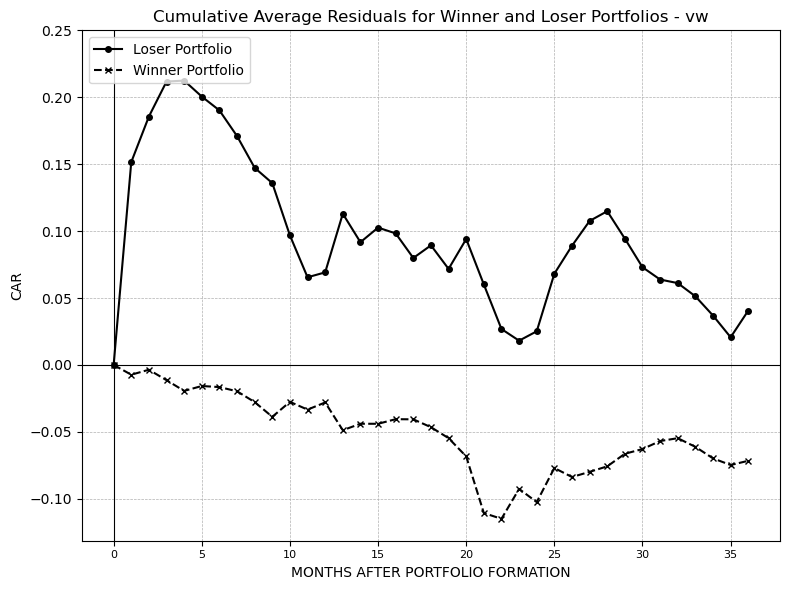

In [314]:
draw_CAR_pictures_modified(bottom_returns_3year_w,top_returns_3year_w,'vw')

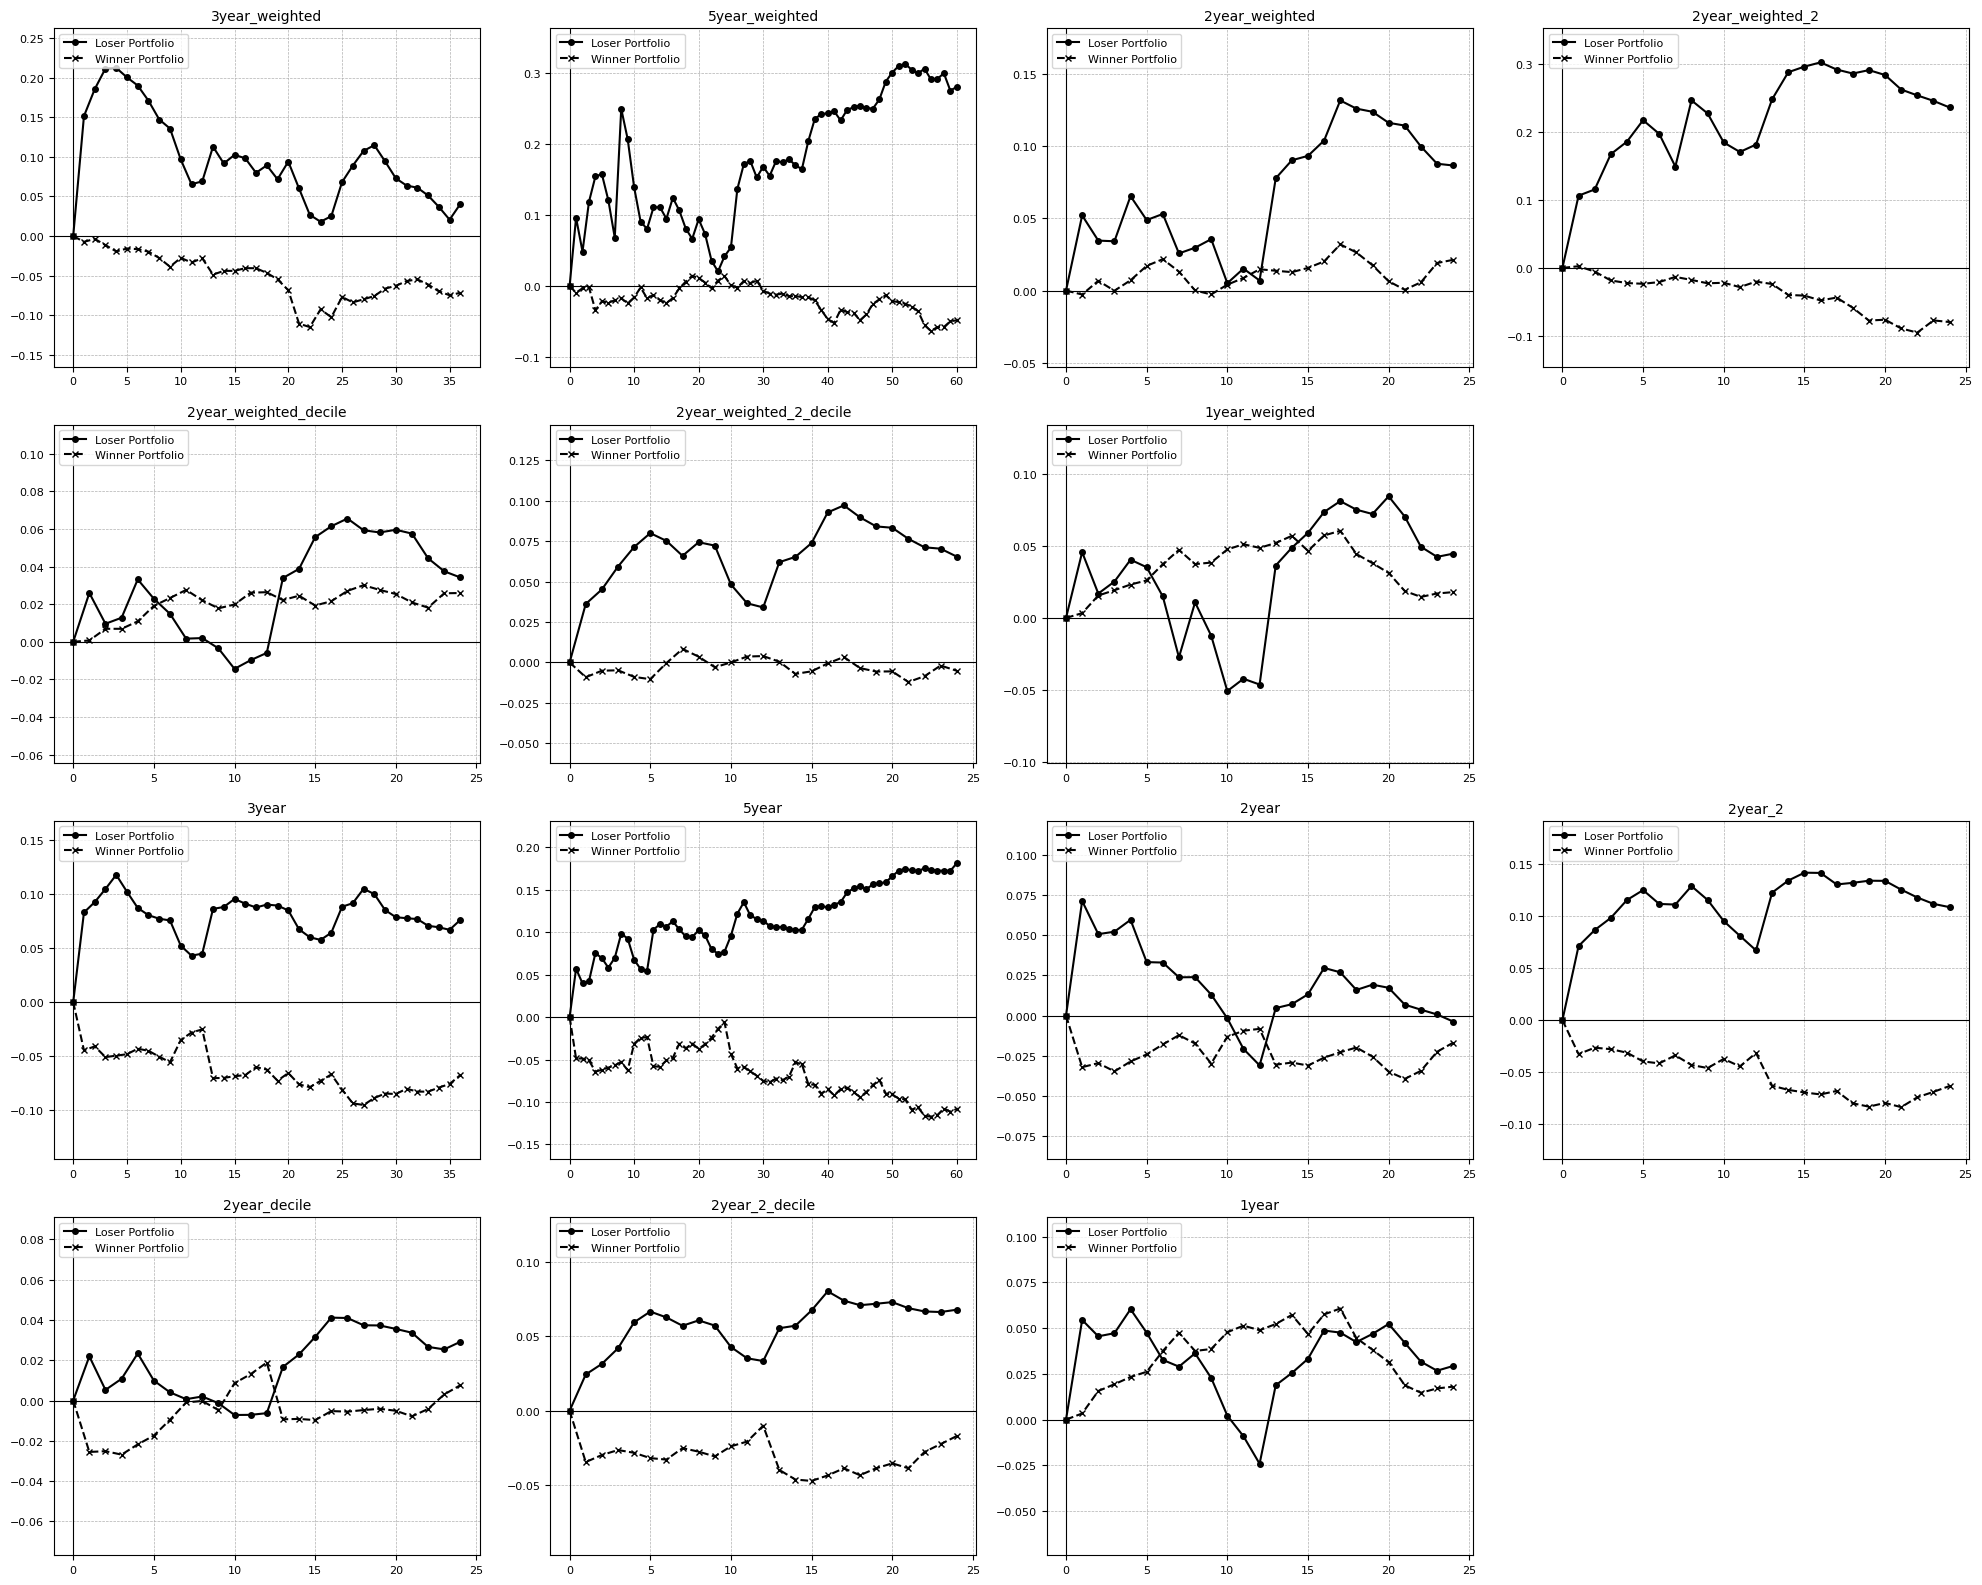

In [315]:
# 将所有 bottom 和 top 合并为 pairs
all_bottom = weighted_bottom + bottom
all_top = weighted_top + top
labels = [
    "3year_weighted", "5year_weighted", "2year_weighted", "2year_weighted_2", "2year_weighted_decile", "2year_weighted_2_decile", "1year_weighted",
    "3year", "5year", "2year", "2year_2", "2year_decile", "2year_2_decile", "1year"
]

# 子图行列布局：4-3-4-3
row_cols = [4, 3, 4, 3]  # 每行子图数量
n_rows = len(row_cols)

# 创建自定义布局的子图网格
fig, axs = plt.subplots(n_rows, max(row_cols), figsize=(20, 16))
axs = axs.flatten()

# 逐行绘制子图
current_index = 0
for row, cols in enumerate(row_cols):
    for col in range(cols):
        if current_index < len(all_bottom):
            ax = axs[row * max(row_cols) + col]  # 按行取对应的子图
            bottom_data = all_bottom[current_index]
            top_data = all_top[current_index]
            ax.plot(bottom_data['months'], bottom_data['CAR'], label='Loser Portfolio', color='black', linestyle='-', marker='o', markersize=4)
            ax.plot(top_data['months'], top_data['CAR'], label='Winner Portfolio', color='black', linestyle='--', marker='x', markersize=4)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            ax.set_title(labels[current_index], fontsize=10)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.legend(loc='upper left', fontsize=8)
            ax.grid(True, linestyle='--', linewidth=0.5)
            
            # 动态调整 y 轴范围
            min_y = min(bottom_data['CAR'].min(), top_data['CAR'].min()) - 0.05  # 下界
            max_y = max(bottom_data['CAR'].max(), top_data['CAR'].max()) + 0.05  # 上界
            ax.set_ylim(min_y, max_y)
            
            current_index += 1
        else:
            # 删除多余的子图
            fig.delaxes(axs[row * max(row_cols) + col])

# 调整布局
plt.tight_layout()
delete_positions = [(2, 4), (4, 4)]  # 指定删除位置 (行, 列)
delete_indices = [(row - 1) * 4 + (col - 1) for row, col in delete_positions]
for idx in delete_indices:
    fig.delaxes(axs[idx])
plt.savefig('D:\\1YFT_Math_and_Finance\\Autumn\\Portfolio Management\\67-23_car.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [37]:
len(period_start_dates_3year)

30

In [253]:
calculate_portfolio_returns_modified(
            period_start_dates_3year[15],
            portfolios_thirtyfive_3year[period_start_dates_3year[15]][0],
            df_crsp,
            'ewretd','ew',36
)


,months,AR,CAR
0,1,-0.004909,-0.004909
1,2,-0.059247,-0.064156
2,3,0.059988,-0.004167
3,4,-0.025496,-0.029663
4,5,-0.003839,-0.033502
5,6,-0.025339,-0.058841
6,7,0.047199,-0.011642
7,8,-0.045981,-0.057622
8,9,-0.012665,-0.070287
9,10,-0.001394,-0.071682


In [265]:
def calculate_s_and_t(period_start_dates, portfolios, price_data, benchmark_type, weight_type, holding_months, average_ar_car_bottom_1, average_ar_car_top_1):

    average_ar_car_bottom = average_ar_car_bottom_1.drop(index=0)
    average_ar_car_bottom = average_ar_car_bottom.reset_index(drop=True)
    average_ar_car_top = average_ar_car_top_1.drop(index=0)
    average_ar_car_top = average_ar_car_top.reset_index(drop=True)


    # 样本数
    num_experiments = len(period_start_dates)
    # 存储每个时间点的 S_t^2
    pooled_variance_sum_bottom = pd.DataFrame(np.zeros_like(average_ar_car_bottom[['AR','CAR']]),columns=['AR','CAR'])
    pooled_variance_sum_top = pd.DataFrame(np.zeros_like(average_ar_car_top[['AR','CAR']]),columns=['AR','CAR'])

    
    
    for date in period_start_dates:
        # 计算单次实验的bottom和top
        bottom_single_AR_CAR = calculate_portfolio_returns_modified(
            date,
            portfolios[date][0],
            price_data,
            benchmark_type,
            weight_type,
            holding_months
        )
        
        top_single_AR_CAR = calculate_portfolio_returns_modified(
            date,
            portfolios[date][1],
            price_data,
            benchmark_type,
            weight_type,
            holding_months
        )
        
        # 计算差值
        minus_AR_CAR_bottom = (bottom_single_AR_CAR[['AR', 'CAR']] - average_ar_car_bottom[['AR', 'CAR']])**2
        minus_AR_CAR_bottom = minus_AR_CAR_bottom.fillna(0)  # 将 NaN 替换为 0
        minus_AR_CAR_top = (top_single_AR_CAR[['AR', 'CAR']] - average_ar_car_top[['AR', 'CAR']])**2
        minus_AR_CAR_top = minus_AR_CAR_top.fillna(0)  # 将 NaN 替换为 0
        pooled_variance_sum_bottom = pooled_variance_sum_bottom + minus_AR_CAR_bottom
        pooled_variance_sum_top = pooled_variance_sum_top + minus_AR_CAR_top
        #print(pooled_variance_sum_top)

    pooled_variance_car = (pooled_variance_sum_bottom + pooled_variance_sum_top)/ (2 * (num_experiments - 1))  # 公式中除以 2(N-1)
    

    acar_diff = average_ar_car_bottom['CAR'] - average_ar_car_top['CAR']
    acar_diff_df = pd.DataFrame(acar_diff)
    acar_diff_df = acar_diff_df.rename(columns={'0':'ACAR Diff'})
    acar_diff_df.index = acar_diff_df.index + 1
    acar_diff_df.index.name = 'month'

    pooled_variance_ar_bottom = np.sqrt(pooled_variance_sum_bottom['AR']/(num_experiments - 1))
    pooled_variance_ar_top = np.sqrt(pooled_variance_sum_top['AR']/(num_experiments - 1))

    # 计算 t 统计量
    t_statistic_car = pd.DataFrame(acar_diff / np.sqrt(2 * pooled_variance_car['CAR'] / num_experiments))
    t_statistic_car = t_statistic_car.rename(columns={'CAR':'t-statistics'})
    t_statistic_car.index = t_statistic_car.index + 1 
    t_statistic_car.index.name = 'month'  

    t_statistic_bottom_ar = pd.DataFrame(average_ar_car_bottom['AR'] / (pooled_variance_ar_bottom / np.sqrt(num_experiments)))
    t_statistic_bottom_ar = t_statistic_bottom_ar.rename(columns={'AR':'loser-AR t-statistics'})
    t_statistic_bottom_ar.index = t_statistic_bottom_ar.index + 1  
    t_statistic_bottom_ar.index.name = 'month'  

    t_statistic_top_ar = pd.DataFrame(average_ar_car_top['AR'] / (pooled_variance_ar_top / np.sqrt(num_experiments)))
    t_statistic_top_ar = t_statistic_top_ar.rename(columns={'AR':'winner-AR t-statistics'})
    t_statistic_top_ar.index = t_statistic_top_ar.index + 1  
    t_statistic_top_ar.index.name = 'month'  
    #return acar_diff_df,t_statistic_car,t_statistic_bottom_ar,t_statistic_top_ar
    combined_df = pd.concat([acar_diff_df, t_statistic_car, t_statistic_bottom_ar, t_statistic_top_ar], axis=1)

    return combined_df

In [135]:
results_t_statistics = []

# 遍历所有的 bottom 和 top 数据集
for i in range(len(bottom)):
    # 获取对应的数据
    bottom_returns = bottom[i]
    top_returns = top[i]
    start_dates = period_start_dates[i]
    portfolio = portfolios[i]

    # 修改 bottom 和 top 数据
    bottom_returns.drop(index=0, inplace=True)
    bottom_returns.reset_index(drop=True, inplace=True)
    top_returns.drop(index=0, inplace=True)
    top_returns.reset_index(drop=True, inplace=True)

    # 计算 t-statistics
    car_t,t_ar_loser, t_ar_winner = calculate_s_and_t(
        start_dates,
        portfolio,
        df_crsp,  # 假设 df_crsp 是全局变量
        "ewretd",
        "ew",
        holding_month[i],  # 假设 holding_months 为 36
        bottom_returns,
        top_returns
    )

    # 保存计算结果
    results_t_statistics.append((car_t,t_ar_loser, t_ar_winner))




In [316]:
results_t_statistics_weighted = []

# 遍历所有的 bottom 和 top 数据集
for i in range(len(bottom)):
    # 获取对应的数据
    bottom_returns_w = weighted_bottom[i]
    top_returns_w = weighted_top[i]
    start_dates = period_start_dates[i]
    portfolio_w = portfolios_w[i]

    # 计算 t-statistics
    final_result = calculate_s_and_t(
        start_dates,
        portfolio_w,
        df_crsp,  # 假设 df_crsp 是全局变量
        "vwretd",
        "vw",
        holding_month[i], 
        bottom_returns_w,
        top_returns_w
    )

    # 保存计算结果
    results_t_statistics_weighted.append((final_result))

In [325]:
results_t_statistics_weighted[0].iloc[[0,11,12,17,23,24,35]]

,CAR,t-statistics,loser-AR t-statistics,winner-AR t-statistics
month,,,,
1,0.158861,2.198261,2.131597,-0.564665
12,0.097207,0.631768,0.100627,0.769427
13,0.161744,1.082401,1.494641,-1.574336
18,0.135880,0.898125,0.732643,-1.178561
24,0.127625,0.744120,0.631114,-1.039413
25,0.145180,0.876374,1.672782,2.426073
36,0.112238,0.617193,1.303210,0.303852
